# Prithvi WxC Downscaling: Model Inference

This notebook is a walk through to use a finetuned downscaling model to generate inferences. We show how to initalize the model, load weights, and use the model for inference

In [2]:
!pip install h5netcdf matplotlib wget pyyaml xarray scipy torch PrithviWxC granitewxc huggingface_hub

In [3]:
import os
import wget
import random
from pathlib import Path

import matplotlib.pyplot as plt
from itertools import product
import numpy as np
import torch
from torch.utils.data import DataLoader
from huggingface_hub import hf_hub_download

from granitewxc.utils.config import get_config
from granitewxc.utils.data import _get_transforms
from granitewxc.datasets.merra2 import Merra2DownscaleDataset
from granitewxc.utils.downscaling_model import get_finetune_model
from PrithviWxC.dataloaders.merra2 import SampleSpec
from granitewxc.utils.plot import *

Configure the backends and torch states, including setting the seeds for the RNGs

In [4]:
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

It is possible to use a cpu or gpu/s to generate inferences. Based on avaiablity of a cuda:gpu we set the device the model uses

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Load Config

We provide a configuration file that is used to configure data variables and model parameters. For inference most of these configurations are used as is. This includes the variables that the model is trained on, the variables that we downscale, the number of input timesteps, the amount of downscaling, the embedding dimensions for the model. When necessary, we will show which configurations need to be specified or changed outside of what is set in this file already.

In [6]:
config_path = hf_hub_download(repo_id="ibm-granite/granite-geospatial-wxc-downscaling",
                            filename="config.yaml",
                            local_dir="./")
config = get_config(config_path)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


### Download Model and Sample Data

We provide sample data from MERRA-2 dataset for a single day (2020 January 01), and [weights](https://huggingface.co/ibm-granite/granite-geospatial-wxc-downscaling/tree/main) for a finetuned downscaling model that we use in this notebook. These will be downloaded when you run the cell/s below

Before running the download set `config.download_path` to the directory where you want the model and sample data to be downloaded

*Note*: With `config.download_path = './'` the files are downloaded in the current working directory

In [7]:
config.download_path = './'

In [8]:
hf_hub_download(repo_id="ibm-granite/granite-geospatial-wxc-downscaling", filename="pytorch_model.bin", local_dir="./")
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="merra-2/MERRA2_sfc_20200101.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="merra-2/MERRA_pres_20200101.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/anomaly_variance_surface.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/anomaly_variance_vertical.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/musigma_surface.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/musigma_vertical.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour00.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour03.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour06.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour09.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour12.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour15.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour18.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour21.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_surface_doy001_hour00.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour00.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour03.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour06.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour09.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour12.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour15.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour18.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour21.nc", local_dir=config.download_path)
hf_hub_download(repo_id="ibm-nasa-geospatial/Prithvi-WxC-1.0-2300M", filename="climatology/climate_vertical_doy001_hour00.nc", local_dir=config.download_path)

'climatology/climate_vertical_doy001_hour00.nc'

Based on the path to the sample data downloaded in the above cells we specify the paths that are required by the dataloaders

In [9]:
config.data.data_path_surface = os.path.join(config.download_path,'merra-2')
config.data.data_path_vertical = os.path.join(config.download_path, 'merra-2')
config.data.climatology_path_surface = os.path.join(config.download_path,'climatology')
config.data.climatology_path_vertical = os.path.join(config.download_path,'climatology')

config.model.input_scalers_surface_path = os.path.join(config.download_path,'climatology/musigma_surface.nc')
config.model.input_scalers_vertical_path = os.path.join(config.download_path,'climatology/musigma_vertical.nc')
config.model.output_scalers_surface_path = os.path.join(config.download_path,'climatology/anomaly_variance_surface.nc')
config.model.output_scalers_vertical_path = os.path.join(config.download_path,'climatology/anomaly_variance_vertical.nc')

### Dataloader

With the environment ready to go, we now need to set up the task. The core model expects a fixed set of variables from the MERRA-2 dataset, which are defined in the configuration file. The variables are comprised of surface variables, surface static variables, and variables at various vertical levels within the atmosphere. More details on the MERRA-2 dataset can be found [here](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/).

The task of the model is, given the input data, to increase the resolution of 2m surface temperature by 6x.

Set the range of the data to the sample data that we downloaded earlier

In [10]:
config.data.val_time_range_start = '2020-01-01T00:00:00'
config.data.val_time_range_end = '2020-01-01T23:59:59'

Initialize `Merra2DownscaleDataset` class.

This class is used to create samples as expected by the downscaling model. Using the transforms specified in the dataset class we coarsen and smoothen the MERRA-2 data to use as a low-resolution input to out model. The original data is used as the corresponding high-resolution data.

In [11]:
dataset = Merra2DownscaleDataset(
    time_range=(config.data.val_time_range_start, config.data.val_time_range_end),
    data_path_surface = config.data.data_path_surface,
    data_path_vertical = config.data.data_path_vertical,
    climatology_path_surface = config.data.climatology_path_surface,
    climatology_path_vertical = config.data.climatology_path_vertical,
    input_surface_vars = config.data.input_surface_vars,
    input_static_surface_vars = config.data.input_static_surface_vars,
    input_vertical_vars = config.data.input_vertical_vars,
    input_levels = config.data.input_levels,
    n_input_timestamps = config.data.n_input_timestamps,
    output_vars=config.data.output_vars,
    transforms=_get_transforms(config),
)

assert len(dataset) > 0, "There doesn't seem to be any valid data."

In [12]:
dataloader = DataLoader(dataset, batch_size=1)

### Model Init

We build the model using the loaded configuration. To use the model for inference with the provided weights we will keep the model configuration the same as defined in the configuration file


The graintewxc downscale model consists of a patch embedding layer, followed by an upscaling layer that increases the resolution by 2x, then we use the pre-trained encoder of the PrithviWxC model followed by another upscaling operation that increases the resolution by 3x for a total of 6x resolution gain

In [13]:
model = get_finetune_model(config, logger=None)
model

Creating the model.
Encoder shifting: False


ClimateDownscaleFinetuneModel(
  (backbone): PrithviWxCEncoderDecoder(
    (lgl_block): LocalGlobalLocalBlock(
      (transformers): ModuleList(
        (0-24): 25 x Transformer(
          (drop_path): DropPath()
          (attention): Sequential(
            (0): LayerNormPassThrough((2560,), eps=1e-05, elementwise_affine=True)
            (1): MultiheadAttention(
              (qkv_layer): Linear(in_features=2560, out_features=7680, bias=False)
              (w_layer): Linear(in_features=2560, out_features=2560, bias=False)
            )
          )
          (ff): Sequential(
            (0): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
            (1): Mlp(
              (net): Sequential(
                (0): Linear(in_features=2560, out_features=10240, bias=True)
                (1): GELU(approximate='none')
                (2): Dropout(p=0.0, inplace=False)
                (3): Linear(in_features=10240, out_features=2560, bias=True)
                (4): Dropout(p=0.0, 

### Load weights

We can now load the weights we downloaded earlier the model that we initialized

In [14]:
weights_path = Path(config.download_path,'pytorch_model.bin')


model.load_state_dict(torch.load(weights_path, weights_only=False, map_location=device))
model.to(device)

ClimateDownscaleFinetuneModel(
  (backbone): PrithviWxCEncoderDecoder(
    (lgl_block): LocalGlobalLocalBlock(
      (transformers): ModuleList(
        (0-24): 25 x Transformer(
          (drop_path): DropPath()
          (attention): Sequential(
            (0): LayerNormPassThrough((2560,), eps=1e-05, elementwise_affine=True)
            (1): MultiheadAttention(
              (qkv_layer): Linear(in_features=2560, out_features=7680, bias=False)
              (w_layer): Linear(in_features=2560, out_features=2560, bias=False)
            )
          )
          (ff): Sequential(
            (0): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
            (1): Mlp(
              (net): Sequential(
                (0): Linear(in_features=2560, out_features=10240, bias=True)
                (1): GELU(approximate='none')
                (2): Dropout(p=0.0, inplace=False)
                (3): Linear(in_features=10240, out_features=2560, bias=True)
                (4): Dropout(p=0.0, 

### Inference

The model is now ready for inference. We are running an inference for only one sample, but you can add a loop to run the inference for multiple samples

In [15]:
import torch
with torch.no_grad():
    model.eval()

    batch = next(iter(dataloader))
    batch = {k: v.to(device) for k, v in batch.items()}
    out = model(batch)

    inputs = batch['x']
    targets = batch['y']
    outputs = out

In [16]:
inputs.shape, targets.shape, outputs.shape

(torch.Size([1, 280, 60, 96]),
 torch.Size([1, 1, 360, 576]),
 torch.Size([1, 1, 360, 576]))

### Plotting

We set the variable names and description and extract the sample information for generating plots

In [17]:
var_name = "T2M"
var_name_title = '2M air temperature'
var_unit = "K"

input_vars = [*config.data.input_surface_vars, *product(config.data.input_vertical_vars, config.data.input_levels)]
input_t2m_index= input_vars.index(var_name)

sample_idx = 0
coarsening_factor = targets.shape[-1] / inputs.shape[-1]
sample_timestamp, sample_it, sample_lt = dataset.dataset.samples[sample_idx][0]
sample_time_spec = SampleSpec.get(sample_timestamp, -sample_it, sample_lt)
sample_time = sample_time_spec.inputs[-1]

f'{var_name_title} at {sample_time} is downscaled by {coarsening_factor}x'

'2M air temperature at 2020-01-01 03:00:00 is downscaled by 6.0x'

In [18]:
plot_input = inputs[0, input_t2m_index, :, :].detach().cpu().numpy()
plot_target = targets[0, 0, : ,:].detach().cpu().numpy()
plot_output = outputs[0, 0, :, :].detach().cpu().numpy()
plot_residual = plot_target - plot_output

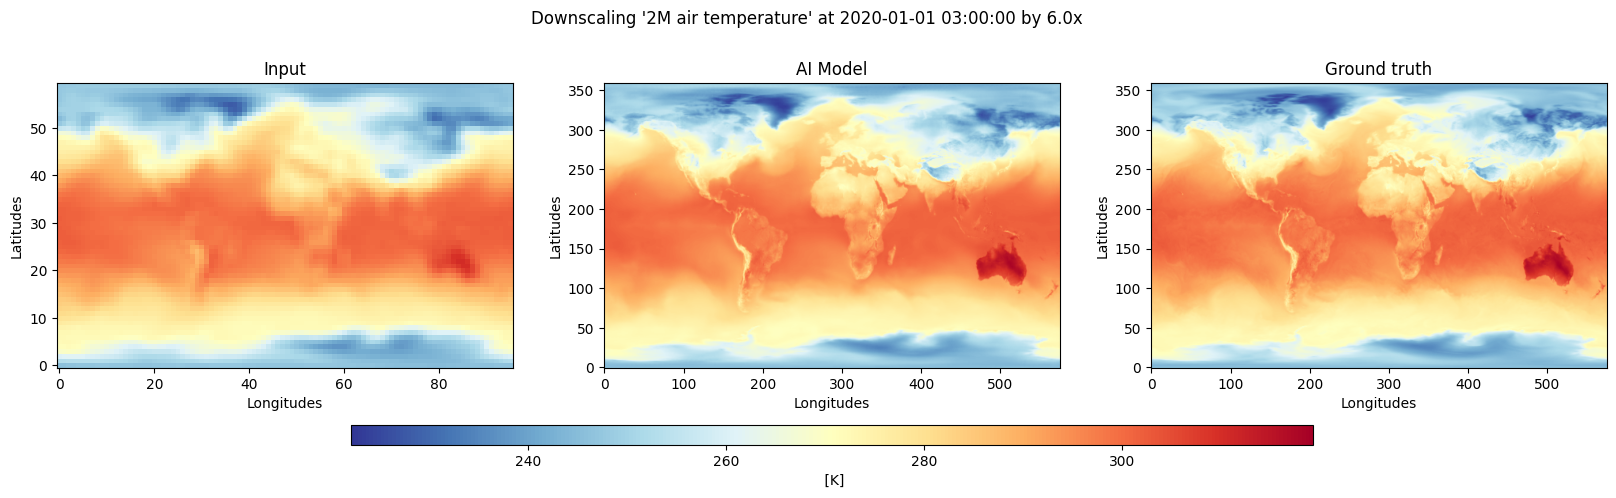

In [19]:
plot_val_kwargs = dict(
    cmap='RdYlBu_r',
    vmin = min(np.min(plot_input), np.min(plot_target), np.min(plot_output)),
    vmax = max(np.max(plot_input), np.max(plot_target), np.max(plot_output)),
    plot_residual_kwargs = dict(
        cmap = 'bwr',
        vmin = -np.max(np.abs(plot_residual)),
        vamx = np.max(np.abs(plot_residual)),
    ),
    var_name_title=var_name_title,
    var_unit=var_unit
)

plot_model_results(
    [plot_input, plot_output, plot_target],
    ['Input', 'AI Model', 'Ground truth'],
    title=f"Downscaling '{var_name_title}' at {sample_time} by {coarsening_factor}x",
    **plot_val_kwargs
)

Text(0.5, 1.0, 'Power spectrum of 2M air temperature')

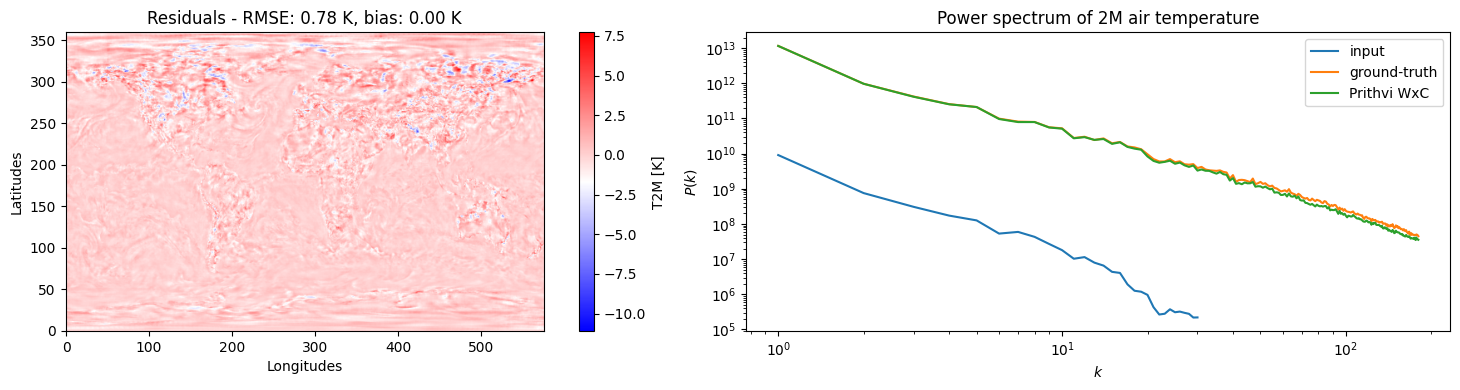

In [20]:
vmin_res = -np.max(np.abs(plot_residual))
vmax_res = np.max(np.abs(plot_residual))
pred_bias = spatial_bias(plot_output, plot_target)
pred_rmse = spatial_rmse(plot_output, plot_target)

fig, axs = plt.subplots(nrows=1,ncols=2,
                        figsize=(15,4))

title = 'Residuals - RMSE: {:.2f} K, bias: {:.2f} K'.format(pred_rmse, pred_bias)
im_res = plot_spatial(plot_residual, axs[0], title,  **plot_val_kwargs.get('plot_residual_kwargs'))
cbar = plt.colorbar(im_res, ax=axs[0], orientation='vertical', label=f'{var_name} [K]')

plot_power_spectrum(plot_input, axs[1])
plot_power_spectrum(plot_target, axs[1])
plot_power_spectrum(plot_output, axs[1])
axs[1].legend(['input', 'ground-truth', 'Prithvi WxC'])
axs[1].set_title(f'Power spectrum of {var_name_title}')